In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
import seaborn as sns

Relu

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Iteration 1
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.7830 - loss: 0.7347 - val_accuracy: 0.9780 - val_loss: 0.0666
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 59ms/step - accuracy: 0.9819 - loss: 0.0583 - val_accuracy: 0.9794 - val_loss: 0.0616
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - accuracy: 0.9864 - loss: 0.0425 - val_accuracy: 0.9864 - val_loss: 0.0407
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9892 - loss: 0.0338 - val_accuracy: 0.9878 - val_loss: 0.0346
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9915 - loss: 0.0269 - val_accuracy: 0.9886 - val_loss: 0.0331
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.9933 - loss: 0.0229 - val_accuracy: 0.9879 - val_loss: 0.0349
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.

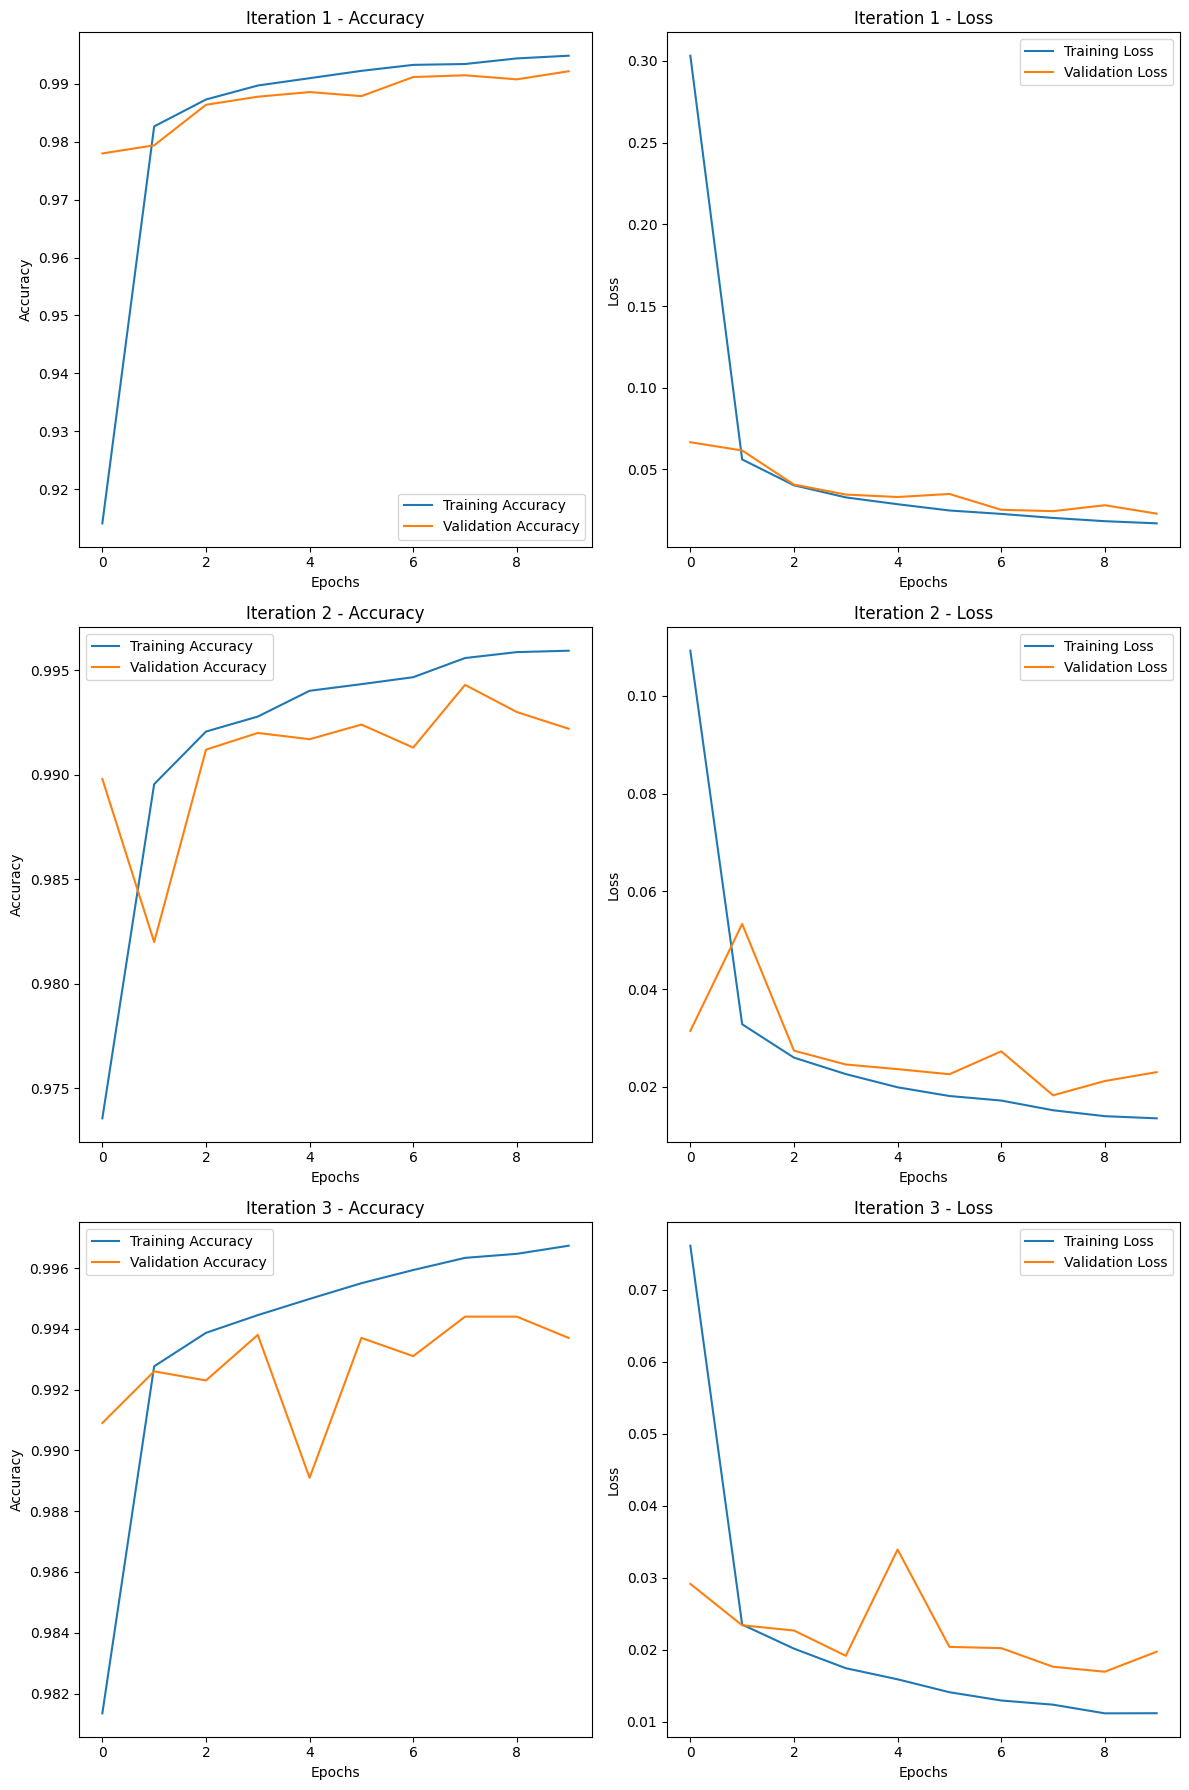

In [2]:
def piecewise_activation(x):
    return tf.where(x > 0, x, tf.zeros_like(x))

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

Tanh

In [ ]:
def piecewise_activation(x):
    return tf.keras.activations.tanh(x)

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

Iteration 1
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.3332 - loss: 2.0337 - val_accuracy: 0.7114 - val_loss: 1.1964
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.7549 - loss: 1.0120 - val_accuracy: 0.8929 - val_loss: 0.5089
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8974 - loss: 0.4575 - val_accuracy: 0.9390 - val_loss: 0.2734
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.9413 - loss: 0.2592 - val_accuracy: 0.9485 - val_loss: 0.2105
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9572 - loss: 0.1823 - val_accuracy: 0.9656 - val_loss: 0.1368
Epoch 6/10


Sigmoid

In [ ]:
def piecewise_activation(x):
    return tf.keras.activations.softsign(x)


# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

Softplus

In [ ]:
def piecewise_activation(x):
    return tf.keras.activations.softplus(x)

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

Softsign

In [ ]:
def piecewise_activation(x):
    return tf.keras.activations.softsign(x)


# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

Swish

In [ ]:
def piecewise_activation(x):
    return tf.keras.activations.swish(x)

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

Mish

In [ ]:
def m_ish(x):
    return x * tf.tanh(tf.math.softplus(x))
def piecewise_activation(x):
    return m_ish(x)


# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

SELU

In [ ]:
def piecewise_activation(x):
    return tf.keras.activations.selu(x)

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

ELU

In [ ]:
def piecewise_activation(x):
    return tf.keras.activations.elu(x)


# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

LRELU

In [ ]:
def piecewise_activation(x):
    return tf.where(x > 0, x, 0.01*(x))

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

ReLU+Tanh

In [ ]:
def piecewise_activation(x):
    return tf.where(x > 0, x, tf.tanh(x))


# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

ReLU+Sigmoid

In [ ]:
def piecewise_activation(x):
    return tf.where(x > 0, x, tf.sigmoid(x))

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

ReLU+Swish

In [ ]:
def piecewise_activation(x):
    return tf.where(x > 0, x, tf.keras.activations.swish(x))


# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

Relu+softsign

In [ ]:
def piecewise_activation(x):
    return tf.where(x > 0, x, tf.keras.activations.softsign(x))

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

Relu+Softplus

In [ ]:
def piecewise_activation(x):
    return tf.where(x > 0, x, tf.keras.activations.softplus(x))

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

ReLU+SELU

In [ ]:
def piecewise_activation(x):
    return tf.where(x > 0, x, tf.keras.activations.selu(x))


# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

ReLU+Mish

In [ ]:
def m_ish(x):
    return x * tf.tanh(tf.math.softplus(x))
def piecewise_activation(x):
    return tf.where(x > 0, x, m_ish(x))

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()

ReLU+ELU

In [ ]:
def piecewise_activation(x):
    return tf.where(x > 0, x, tf.keras.activations.elu(x))


# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28,28,1) to 3-channel RGB (28,28,3)
train_images = np.stack((train_images,) * 3, axis=-1)  # Convert (28,28,1) to (28,28,3)
test_images = np.stack((test_images,) * 3, axis=-1)    # Convert (28,28,1) to (28,28,3)

# Resize images to (32,32,3) for VGG16
train_images = tf.image.resize(train_images, (32, 32)).numpy()
test_images = tf.image.resize(test_images, (32, 32)).numpy()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Load VGG16 as base model (without top layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))

# Apply custom activation to layers
for layer in base_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = piecewise_activation

# Function to create and compile model
def create_model():
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Store results across iterations
accuracies = []
precisions = []
recalls = []
f1_scores = []
iterations = 3

# Create figures for plotting results
fig, axes = plt.subplots(iterations, 2, figsize=(12, 6 * iterations))

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}")

    # Create a new model for each iteration
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification Report
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    print("Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, digits=4, zero_division=0)
    print(report)

    # Append metrics to lists
    accuracies.append(test_acc)

    # Extract precision, recall, F1 score from classification report
    report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report_dict['accuracy']
    recall = report_dict['accuracy']
    f1_score = report_dict['accuracy']
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # Plot accuracy and loss for the iteration
    axes[iteration, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[iteration, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[iteration, 0].set_title(f"Iteration {iteration + 1} - Accuracy")
    axes[iteration, 0].set_xlabel('Epochs')
    axes[iteration, 0].set_ylabel('Accuracy')
    axes[iteration, 0].legend()

    axes[iteration, 1].plot(history.history['loss'], label='Training Loss')
    axes[iteration, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[iteration, 1].set_title(f"Iteration {iteration + 1} - Loss")
    axes[iteration, 1].set_xlabel('Epochs')
    axes[iteration, 1].set_ylabel('Loss')
    axes[iteration, 1].legend()

# Calculate the average of all metrics across iterations
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy across {iterations} iterations: {avg_accuracy:.4f}")
print(f"Average Precision across {iterations} iterations: {avg_precision:.4f}")
print(f"Average Recall across {iterations} iterations: {avg_recall:.4f}")
print(f"Average F1-Score across {iterations} iterations: {avg_f1:.4f}")

# Show all iteration plots
plt.tight_layout()
plt.show()